<a href="https://colab.research.google.com/github/dhruvphansalkar/CrisisNLPClassification/blob/main/Reduced_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
data_path = os.path.join(os.getcwd(), "drive", "My Drive", "cs6301-sp23", "project_data", "data", "MergeResult_3.tsv")

Mounted at /content/drive


In [4]:
!pip install transformers datasets evaluate
!pip install tweet-preprocessor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [5]:
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import Dict, List, Set, Tuple

import numpy as np
import nltk
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm, trange
nltk.download("punkt")
import pandas as pd
from datasets import Dataset, load_metric
from datasets.load import load_dataset
from transformers import AutoTokenizer
import preprocessor as p
from transformers import TrainingArguments, Trainer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
pd.options.display.max_colwidth = 1000

In [8]:
def fetch_data_from_csv(path):
  df = pd.read_table(path)
  df = pd.DataFrame(df)
  #return Dataset.from_pandas(df)
  return df

In [9]:
def convertDFtoDataSet(df):
  ds = Dataset.from_pandas(df)
  return ds

In [10]:
data = fetch_data_from_csv(data_path)


In [11]:
def reduceClasses(classVal):
  if classVal == 'other_useful_information' or classVal == 'caution_and_advice' or classVal == 'sympathy_and_emotional_support' or classVal == 'not_related_or_irrelevant':
    return 'not_related_or_irrelevant'
  elif classVal == 'injured_or_dead_people' or classVal == 'missing_trapped_or_found_people' or classVal == 'infrastructure_and_utilities_damage':
    return 'emergency_services_required'
  else:
    return 'donation_needs_or_offers_or_volunteering_services'
  

In [12]:
data['label'] = data['label'].apply(lambda lab: reduceClasses(lab))

In [13]:
def understandData(df):
  print('--------------------------------Shape of the data is--------------------------')
  print(data.shape)

  print('----------------------the data contains following fields----------------------')
  print(data.columns)

  print('---------------------------------Data Description-----------------------------')
  print(data.describe)

  print('---------------------------------label count----------------------------------')
  print(data['label'].value_counts())

In [14]:
understandData(data)

--------------------------------Shape of the data is--------------------------
(17382, 3)
----------------------the data contains following fields----------------------
Index(['tweet_id', 'tweet_text', 'label'], dtype='object')
---------------------------------Data Description-----------------------------
<bound method NDFrame.describe of                    tweet_id  \
0      '383600460340666369'   
1      '383790723222364161'   
2      '384232048124518400'   
3      '384860484643475456'   
4      '383407962619772928'   
...                     ...   
17377  '592126024437125121'   
17378  '593819547372638208'   
17379  '592137869482799104'   
17380  '591936980096659456'   
17381  '592344448887029761'   

                                                                                                                                         tweet_text  \
0      RT @Faiz_Baluch: #BalochistanEarthQuake Pakistan army is terrorizing the people by aerial firing in #Awaran https://t.co/R3R5ph8

In [15]:
id2label = {0: 'not_related_or_irrelevant', 1: 'emergency_services_required', 2: 'donation_needs_or_offers_or_volunteering_services'}
label2id = {'not_related_or_irrelevant': 0, 'emergency_services_required': 1, 'donation_needs_or_offers_or_volunteering_services': 2}

In [16]:
def exploratoryAnalysis(df):
  
  plt.figure(figsize=(8,6))
  sns.set_style(style='darkgrid')
  ax = sns.countplot(x = 'label', data = df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.title('Class Distribution')
  plt.show()

  plt.figure(figsize=(6,8))
  sns.set_style("darkgrid")
  df['label'].value_counts().plot.pie(autopct='%0.2f%%')
  plt.title("Percentage Contribution")
  plt.xlabel("percent contribution")
  plt.ylabel("label")
  plt.show()

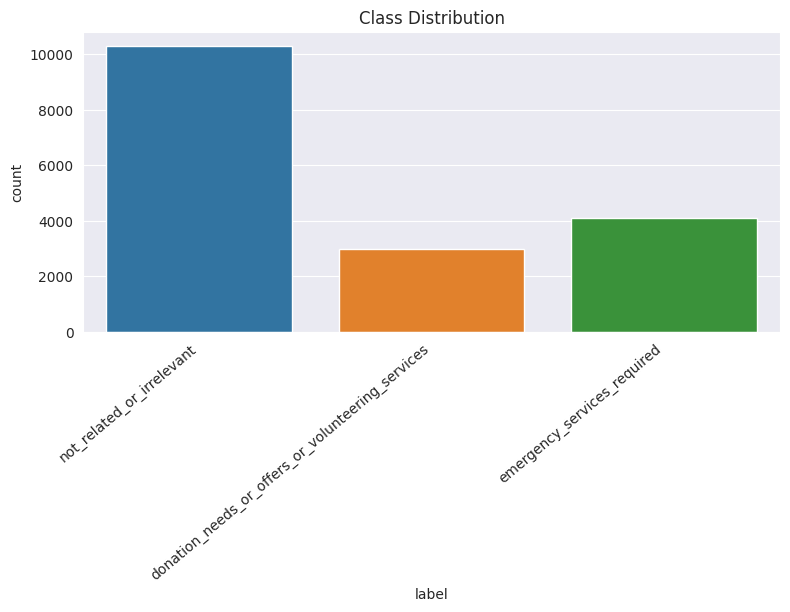

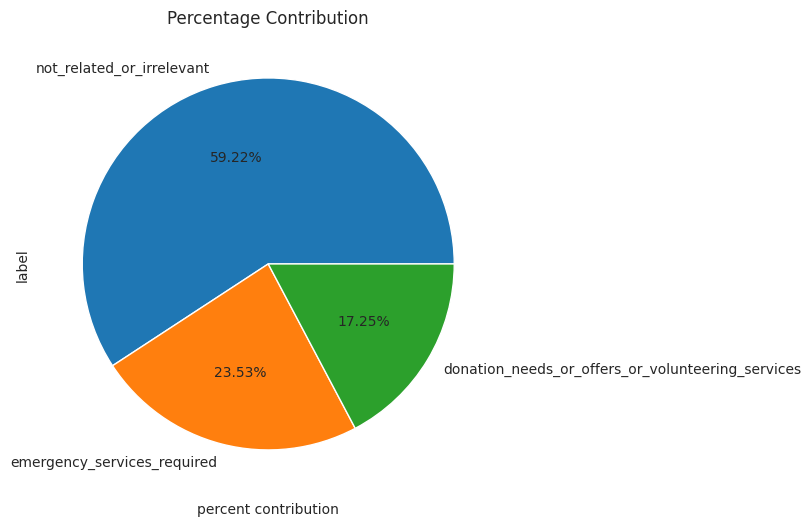

In [17]:
exploratoryAnalysis(data)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
nltk.download('stopwords')
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def cleaner(text):

    cleaned = p.clean(text)
    cleaned=cleaned.replace("//"," ").replace("."," ")
    cleaned=re.sub(r'[^a-zA-Z]'," ",cleaned)
    cleaned=cleaned.strip() #removing whitespace
    cleaned=cleaned.lower() #converting into lower case words
    cleaned=re.sub(r'\w+\d+'," ",cleaned)#remove alphanumeric words
    cleaned=ps.stem(cleaned) #stemming 
    cleaned=[word for word in cleaned.split() if len(word)>2]
    cleaned=" ".join(cleaned)
    return cleaned

In [ ]:
#cleaning data
data['tweet_text'] = data['tweet_text'].apply(lambda text:cleaner(text))

In [ ]:
#converting label to id
def labeltoId(label):
  return label2id[label]

data['label'] = data['label'].apply(lambda label: labeltoId(label))

In [ ]:
dataset_data = convertDFtoDataSet(data)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_data(dataset_data):
    return tokenizer(dataset_data["tweet_text"], padding='max_length')

In [ ]:
tokenized_data = dataset_data.map(tokenize_data, batched = True)

Map:   0%|          | 0/17382 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments("test_trainer", num_train_epochs=3)

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
tokenized_data = tokenized_data.train_test_split(test_size=0.1)
train_d = tokenized_data['train'].shuffle(seed=10)
eval_d = tokenized_data['test'].shuffle(seed=10)

In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-28-c203b637589b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_d, eval_dataset=eval_d
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.578300
1000,0.469200


In [ ]:
trainer.evaluate()

In [ ]:
# Get predictions on the test dataset
test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_labels = eval_d["label"]

In [ ]:
# Compute predicted class indices
predicted_class_indices = np.argmax(test_logits, axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, predicted_class_indices)

In [ ]:
# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']


plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
correct_predictions = np.sum(np.diag(confusion_mat))
total_predictions = np.sum(confusion_mat)
accuracy = correct_predictions / total_predictions
print(accuracy)